In [1]:
# -*- coding: utf-8 -*-
"""
type(fc, gain, Q) 

enum IIR_BIQUARD_TYPE {
    IIR_BIQUARD_PASS = 0,   // pass through
    IIR_BIQUARD_RAW,        // raw filter
    IIR_BIQUARD_LPF,        // 低通滤波器 low pass filter
    IIR_BIQUARD_HPF,        // 高通滤波器 high pass filter
    IIR_BIQUARD_BPF0,       // 带通滤波器 band pass filter, constant skirt gain, peak gain = Q
    IIR_BIQUARD_BPF1,       // 带通滤波器 band pass filter, const 0 dB peak gain
    IIR_BIQUARD_NOTCH,      // 陷波滤波器 notch filter
    IIR_BIQUARD_APF,        // 全通滤波器 allpass filter
    IIR_BIQUARD_PEAKINGEQ,  // 峰值滤波器 peakingEQ
    IIR_BIQUARD_LOWSHELF,   // 低切滤波器 low shelf filter
    IIR_BIQUARD_HIGHSHELF,  // 高切滤波器 high shelf filter
    IIR_BIQUARD_QTY         // number of biquard types
};
https://github.com/3ll3d00d/beqdesigner/blob/master/src/main/python/model/iir.py
http://www.musicdsp.org/files/Audio-EQ-Cookbook.txt
https://github.com/Fxing-Zh/Equalizer
"""
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy import signal


# # alpha = np.sin(w0) * np.sinh(np.log(2) / 2 * BW * w0 / np.sin(w0))  # 用于所有滤波器类型的中间变量(BW)
# # alpha = np.sin(w0)/2* np.sqrt((A + 1/A)*(1/S - 1) + 2)  # 用于所有滤波器类型的中间变量(S)
# 必要参数
# dBgain = 0.1  # 仅用于峰值和shelving滤波器
# Q = 1  # 对定义进行了调整，以便在相同Q和f0/Fs的情况下提高N dB，然后减少N dB，从而产生精确平坦的单位增益滤波器
# BW = 1  # 以倍频程为单位的带宽（BPF 的 -3 dB 频率之间）和陷波或中点 (dBgain/2) 增益频率之间峰值均衡器
# S = 1  # "搁架斜率"参数（仅适用于搁置均衡器）。 当S=1时，陆架坡度尽可能陡并保持单调随着频率的增加或减少增益。 陆架坡度，在dB/倍频程，对于 a 的所有其他值仍与 S 成比例固定 f0/Fs 和 dBgain。
# 
# # 几个中间变量
# A = 10 ** (dBgain / 40)  # dBgain 转换为增益因子(仅适用于峰值和倾斜 EQ 滤波器)
# w0 = 2 * np.pi * f0 / fs  # 角频率

In [2]:
class FilterType():
    def __init__(self, fs=16000):
        self.fs = fs

    def LowpassFilter(self, fc, Q=1 / np.sqrt(2.0)):
        """ 低通滤波器(Low Pass Filter) 
        LPF: H(s) = 1 / (s^2 + s/Q + 1)
        
        b0 = (1 - cos(w0))/2;
        b1 = 1 - cos(w0);
        b2 = (1 - cos(w0))/2;
        a0 = 1 + alpha;
        a1 = -2*cos(w0);
        a2 = 1 - alpha;
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = (1.0 - cos_w0) / 2.0
        b1 = 1.0 - cos_w0
        b2 = (1.0 - cos_w0) / 2.0
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def HighpassFilter(self, fc, Q=1 / np.sqrt(2)):
        """ 高通滤波器(High Pass Filter) 
        HPF: $H(s)=\frac{s^2}{s^2 + s/Q + 1}$
            b0 = (1 + cos(w0))/2
            b1 = -(1 + cos(w0))
            b2 = (1 + cos(w0))/2
            a0 = 1 + alpha
            a1 = -2*cos(w0)
            a2 = 1 - alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = (1.0 + cos_w0) / 2.0
        b1 = -(1.0 + cos_w0)
        b2 = (1.0 + cos_w0) / 2.0
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def BandpassFilter_Q(self, fc, Q):
        """带通 Band Pass Filter (增益 = Q)
        BPF: H(s) = s / (s^2 + s/Q + 1) (constant skirt gain, peak gain = Q)
            b0 =   sin(w0)/2  =   Q*alpha
            b1 =   0
            b2 =  -sin(w0)/2  =  -Q*alpha
            a0 =   1 + alpha
            a1 =  -2*cos(w0)
            a2 =   1 - alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = sin_w0 / 2.0  # Q*alpha
        b1 = 0.0
        b2 = -sin_w0 / 2.0  # -Q*alpha
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def BandpassFilter_0dB(self, fc, Q=1 / np.sqrt(2)):
        """带通 Band Pass Filter( 0 db增益）
        BPF: H(s) = (s/Q) / (s^2 + s/Q + 1) (constant 0 dB peak gain)
            b0 =   alpha
            b1 =   0
            b2 =  -alpha
            a0 =   1 + alpha
            a1 =  -2*cos(w0)
            a2 =   1 - alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = alpha
        b1 = 0.0
        b2 = -alpha
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0
    
    def NotchFilter(self, fc, Q=1 / np.sqrt(2)):
        """Notch滤波器
        notch: H(s) = (s^2 + 1) / (s^2 + s/Q + 1)$
            b0 =   1
            b1 =  -2*cos(w0)
            b2 =   1
            a0 =   1 + alpha
            a1 =  -2*cos(w0)
            a2 =   1 - alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = 1.0
        b1 = -2.0 * cos_w0
        b2 = 1.0
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def AllpassFilter(self, fc, Q=1 / np.sqrt(2)):
        """全通 All Pass Filter
        APF: H(s) = (s^2 - s/Q + 1) / (s^2 + s/Q + 1)$
            b0 =   1 - alpha
            b1 =  -2*cos(w0)
            b2 =   1 + alpha
            a0 =   1 + alpha
            a1 =  -2*cos(w0)
            a2 =   1 - alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # ---------------------------------------------
        b0 = 1.0 - alpha
        b1 = -2.0 * cos_w0
        b2 = 1.0 + alpha
        a0 = 1.0 + alpha
        a1 = -2.0 * cos_w0
        a2 = 1.0 - alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def PeakingFilter(self, fc, dBgain, Q=1 / np.sqrt(2)):
        """峰值滤波器
        peakingEQ: H(s) = (s^2 + s*(A/Q) + 1) / (s^2 + s/(A*Q) + 1)
            b0 =   1 + alpha*A
            b1 =  -2*cos(w0)
            b2 =   1 - alpha*A
            a0 =   1 + alpha/A
            a1 =  -2*cos(w0)
            a2 =   1 - alpha/A
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        # cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # gain、A 仅用于峰值和shelf滤波器
        dBgain = round(float(dBgain), 3)
        A = 10 ** (dBgain / 40)
        # ---------------------------------------------
        b0 = 1 + alpha * A
        b1 = -2 * np.cos(w0)
        b2 = 1 - alpha * A
        a0 = 1 + alpha / A
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha / A
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def LowshelfFilter(self, fc, dBgain, Q=1 / np.sqrt(2)):
        """低切滤波器
        lowShelf: H(s) = A * (s^2 + (sqrt(A)/Q)*s + A)/(A*s^2 + (sqrt(A)/Q)*s + 1)
            b0 =    A*( (A+1) - (A-1)*cos(w0) + 2*sqrt(A)*alpha )
            b1 =  2*A*( (A-1) - (A+1)*cos(w0)                   )
            b2 =    A*( (A+1) - (A-1)*cos(w0) - 2*sqrt(A)*alpha )
            a0 =        (A+1) + (A-1)*cos(w0) + 2*sqrt(A)*alpha
            a1 =   -2*( (A-1) + (A+1)*cos(w0)                   )
            a2 =        (A+1) + (A-1)*cos(w0) - 2*sqrt(A)*alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # gain、A 仅用于峰值和shelf滤波器
        dBgain = round(float(dBgain), 3)
        A = 10.0 ** (dBgain / 40.0)
        # ---------------------------------------------
        b0 = A * ((A + 1) - (A - 1) * cos_w0 + 2 * np.sqrt(A) * alpha)
        b1 = 2 * A * ((A - 1) - (A + 1) * cos_w0)
        b2 = A * ((A + 1) - (A - 1) * cos_w0 - 2 * np.sqrt(A) * alpha)
        a0 = (A + 1) + (A - 1) * cos_w0 + 2 * np.sqrt(A) * alpha
        a1 = -2 * ((A - 1) + (A + 1) * cos_w0)
        a2 = (A + 1) + (A - 1) * cos_w0 - 2 * np.sqrt(A) * alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

    def HighshelfFilter(self, fc, dBgain, Q=1 / np.sqrt(2)):
        """高切滤波器
        highShelf: H(s) = A * (A*s^2 + (sqrt(A)/Q)*s + 1)/(s^2 + (sqrt(A)/Q)*s + A)
            b0 =    A*( (A+1) + (A-1)*cos(w0) + 2*sqrt(A)*alpha )
            b1 = -2*A*( (A-1) + (A+1)*cos(w0)                   )
            b2 =    A*( (A+1) + (A-1)*cos(w0) - 2*sqrt(A)*alpha )
            a0 =        (A+1) - (A-1)*cos(w0) + 2*sqrt(A)*alpha
            a1 =    2*( (A-1) - (A+1)*cos(w0)                   )
            a2 =        (A+1) - (A-1)*cos(w0) - 2*sqrt(A)*alpha
        """
        # 中间变量
        w0 = 2.0 * np.pi * fc / self.fs  # 角频率
        cos_w0 = np.cos(w0)  # cos(w0)
        sin_w0 = np.sin(w0)  # sin(w0)
        alpha = sin_w0 / (2.0 * Q)  # alpha
        # gain、A 仅用于峰值和shelf滤波器
        dBgain = round(float(dBgain), 3)
        A = 10.0 ** (dBgain / 40.0)
        # ---------------------------------------------
        b0 = A * ((A + 1) + (A - 1) * cos_w0 + 2 * np.sqrt(A) * alpha)
        b1 = -2 * A * ((A - 1) + (A + 1) * cos_w0)
        b2 = A * ((A + 1) + (A - 1) * cos_w0 - 2 * np.sqrt(A) * alpha)
        a0 = (A + 1) - (A - 1) * cos_w0 + 2 * np.sqrt(A) * alpha
        a1 = 2 * ((A - 1) - (A + 1) * cos_w0)
        a2 = (A + 1) - (A - 1) * cos_w0 - 2 * np.sqrt(A) * alpha
        numerator_B = np.array([b0, b1, b2], dtype=np.float32)
        denominator_A = np.array([a0, a1, a2], dtype=np.float32)
        return numerator_B / a0, denominator_A / a0

In [3]:
def PlotFilterFreqResponse(b, a, fs, fc, filter_type="LPF"):
    # 根据a\b系数计算滤波器的频率响应
    # 根据系数计算滤波器的频率响应，w是角频率，h是频率响应
    w, h = signal.freqz(b, a)
    # 0.5*fs*w/np.pi 为频率
    plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(h))
    plt.title(f'{filter_type} frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(which='both', axis='both')  # 显示网格
    # 画红色的垂直线，标记截止频率
    plt.axvline(fc, color='red')
    plt.xscale('log')  # x轴对数化
    plt.show()

C:\Users\anker\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\anker\AppData\Roaming\Python\Python311\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


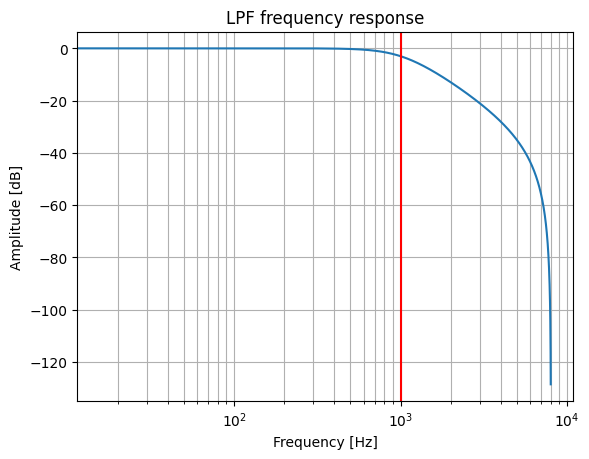

C:\Users\anker\AppData\Local\Temp\ipykernel_2592\4089111284.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(h))
C:\Users\anker\AppData\Local\Temp\ipykernel_2592\4089111284.py:6: RuntimeWarning: invalid value encountered in multiply
  plt.plot(0.5 * fs * w / np.pi, 20 * np.log10(h))


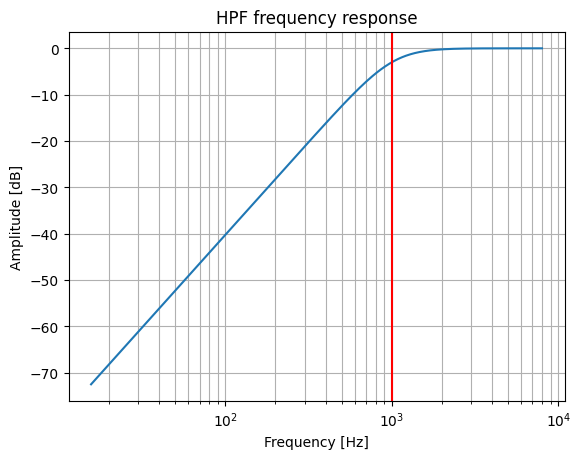

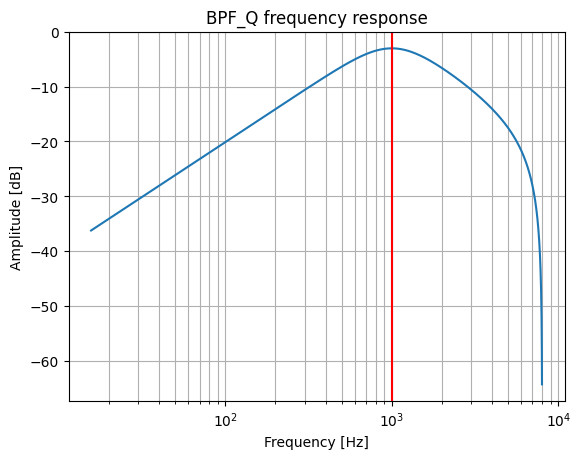

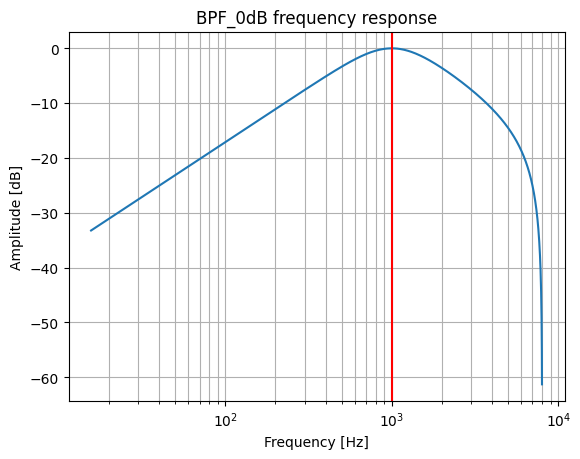

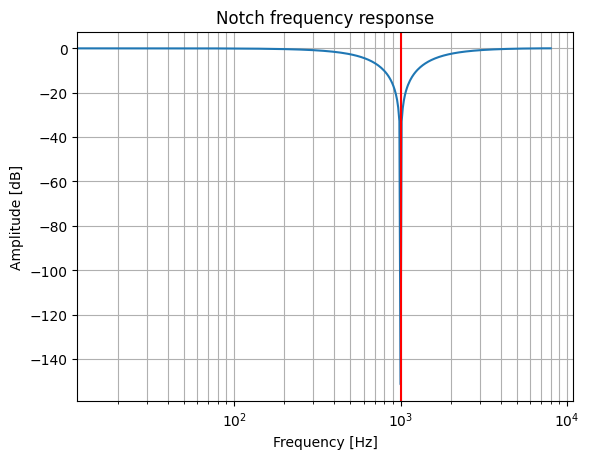

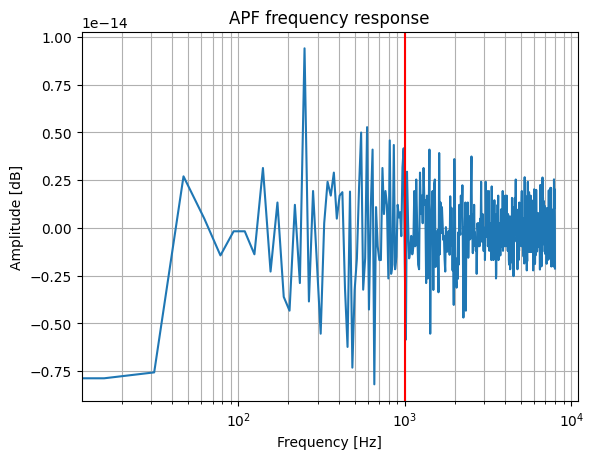

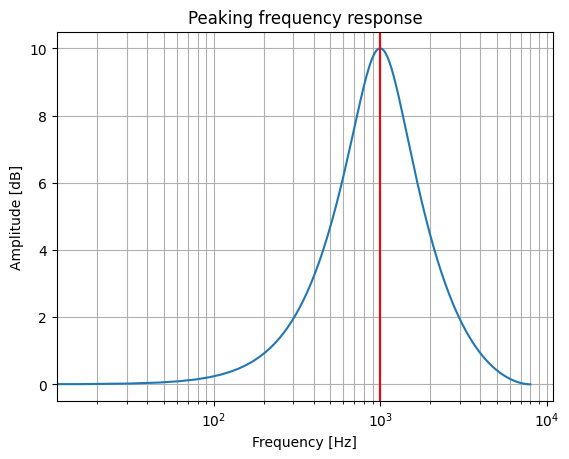

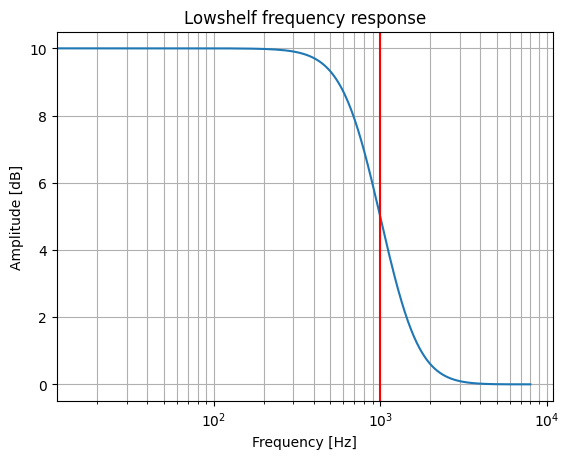

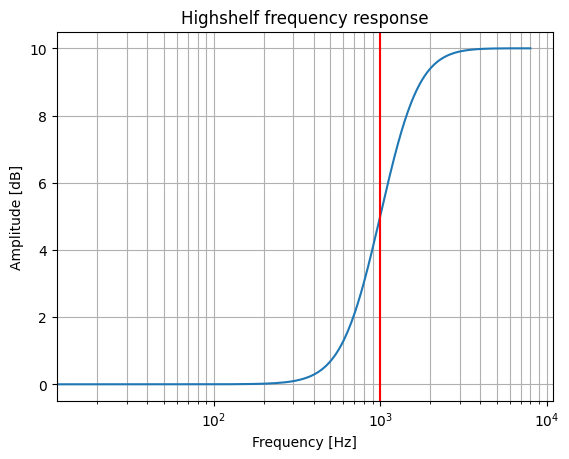

In [4]:
fs = 16000
fc = 1000
Q = 1 / np.sqrt(2)
dBgain = 10
FilterEQ = FilterType(fs)
# 低通滤波器
b, a = FilterEQ.LowpassFilter(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="LPF")
# 高通滤波器
b, a = FilterEQ.HighpassFilter(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="HPF")
# 带通滤波器
b, a = FilterEQ.BandpassFilter_Q(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="BPF_Q")
# 带通滤波器
b, a = FilterEQ.BandpassFilter_0dB(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="BPF_0dB")
# 陷波滤波器
b, a = FilterEQ.NotchFilter(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="Notch")
# 全通滤波器
b, a = FilterEQ.AllpassFilter(fc, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="APF")
# 峰值滤波器
b, a = FilterEQ.PeakingFilter(fc, dBgain, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="Peaking")
# 低切滤波器
b, a = FilterEQ.LowshelfFilter(fc, dBgain, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="Lowshelf")
# 高切滤波器
b, a = FilterEQ.HighshelfFilter(fc, dBgain, Q)
PlotFilterFreqResponse(b, a, fs, fc, filter_type="Highshelf")


# EQ 

通过多个Biquand滤波器，组成一个EQ滤波器，实现音频的均衡处理。

In [5]:
class BiquadFilter():
    def __init__(self, b, a):
        self.b0, self.b1, self.b2 = b
        _, self.a1, self.a2 = a
        self.x1, self.x2, self.y1, self.y2 = 0, 0, 0, 0

    def process(self, x):
        # biquad公式：y[n] = b0*x[n] + b1*x[n-1] + b2*x[n-2] - a1*y[n-1] - a2*y[n-2]
        y = (self.b0 * x + self.b1 * self.x1 + self.b2 * self.x2 
             - self.a1 * self.y1 - self.a2 * self.y2)
        self.x2 = self.x1
        self.x1 = x
        self.y2 = self.y1
        self.y1 = y
        return y

In [6]:
def show_frequency_response(filter, samplerate):
    size = 512
    signal = [1] + [0] * (size - 1)    # 冲激信号 [1,0,0,0...0]
    # 对该信号通过滤波器处理
    for filt in filter:
        signal = [filt.process(item) for item in signal]
    # 对处理后的信号进行零填充，以匹配采样率的长度
    filler = [0] * (samplerate - size)  # zero-padding
    signal += filler   # 现在 len(outputs) = samplerate
    
    fft_out = np.abs(np.fft.fft(signal))    # FFT
    fft_db = 20 * np.log10(fft_out) # to dB

    # Frequencies on log scale from 24 to nyquist frequency
    plt.xlim(24, samplerate / 2 - 1)
    plt.xscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Gain (dB)")

    plt.plot(fft_db)
    plt.grid()
    plt.show()


def show_phase_response(filter, samplerate):
    size = 512
    outputs = [1] + [0] * (size - 1)
    for filt in filter:
        outputs = [filt.process(item) for item in outputs]

    filler = [0] * (samplerate - size)
    outputs += filler
    fft_out = np.angle(np.fft.fft(outputs))
    plt.xlim(24, samplerate / 2 - 1)
    plt.ylim(-np.pi, np.pi)
    plt.xscale("log")

    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Phase shift (Radians)")
    plt.plot(np.unwrap(fft_out, -2 * np.pi))
    plt.grid()
    plt.show()

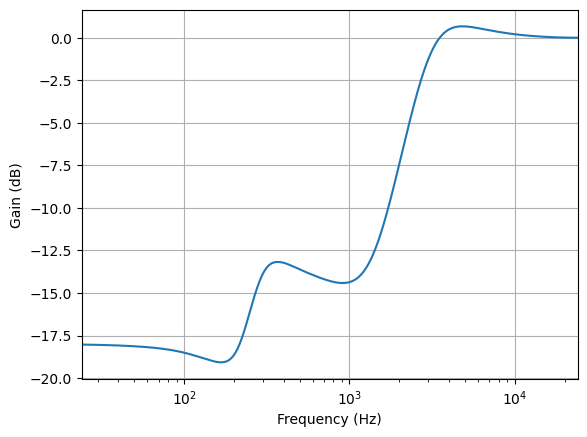

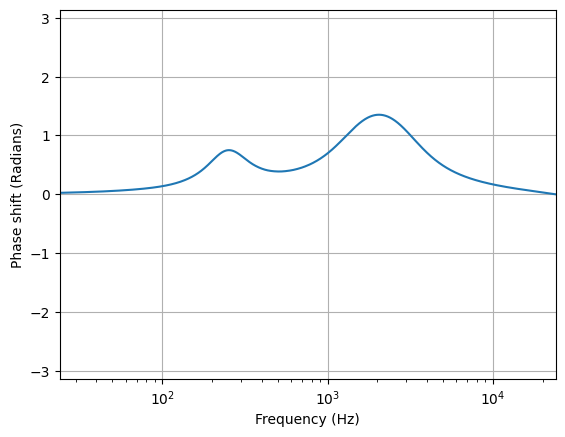

In [7]:

fs = 48000
FilterEQ = FilterType(fs)
# 低通滤波器
b, a = FilterEQ.LowshelfFilter(2056,-14,0.95)
BiquadFilter1 = BiquadFilter(b, a)
# 高通滤波器
b, a = FilterEQ.LowshelfFilter(250, -4, 1.44)
BiquadFilter2 = BiquadFilter(b, a)

filt = [BiquadFilter1, BiquadFilter2]
show_frequency_response(filt, fs)
show_phase_response(filt, fs)